1. 计算基线值（可以是信号的中位数）。  
2. 计算信号的标准差。  
3. 将冲激定义为超过基线值加上一定倍数的标准差的部分。  
4. 计算冲激部分的 5% 和 95% 分位数，以获得 90% 的范围。  

Calculated Ranges: {'S0': (1937.0, 2134.0), 'S1': (1892.0, 2089.35), 'S2': (1899.0, 2034.1), 'S3': (1823.0, 1892.0)}


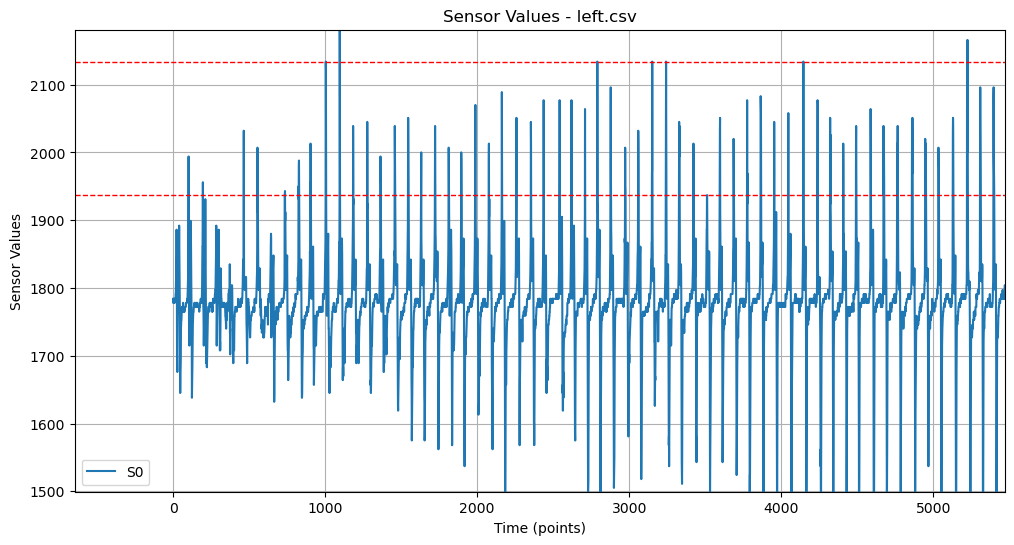

In [6]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk

class SensorAnalyzer:
    def __init__(self, master):
        self.master = master
        self.master.title("CSV File Opener")
        
        self.column_names = ['S0', 'S1', 'S2', 'S3']
        self.selected_sensors = {name: tk.BooleanVar(value=True) for name in self.column_names}
        
        self.filepath = None
        self.data = None
        
        self.create_widgets()
        
    def create_widgets(self):
        # Create a button to open the file dialog
        btn_open = tk.Button(self.master, text="Open CSV File", command=self.open_file)
        btn_open.pack(pady=10)
        
        # Create checkboxes for selecting sensors
        self.checkbox_frame = tk.Frame(self.master)
        self.checkbox_frame.pack()
        
        for sensor in self.column_names:
            chk = tk.Checkbutton(self.checkbox_frame, text=sensor, variable=self.selected_sensors[sensor], command=self.update_plot)
            chk.pack(side=tk.LEFT)
        
        # Create a frame for matplotlib plot
        self.plot_frame = tk.Frame(self.master)
        self.plot_frame.pack(fill=tk.BOTH, expand=True)
        
        self.canvas = None
        self.toolbar = None
    
    def open_file(self):
        self.filepath = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if not self.filepath:
            return
        
        self.data = pd.read_csv(self.filepath)
        self.data.columns = self.column_names
        self.calculate_ranges()
        self.update_plot()
    
    def calculate_ranges(self):
        self.ranges = {}
        for sensor in self.column_names:
            baseline = self.data[sensor].median()
            std_dev = self.data[sensor].std()
            threshold = baseline + 2 * std_dev  # 定义冲激的阈值
            
            impulses = self.data[sensor][self.data[sensor] > threshold]
            if not impulses.empty:
                lower = impulses.quantile(0.05)
                upper = impulses.quantile(0.95)
                self.ranges[sensor] = (lower, upper)
            else:
                self.ranges[sensor] = (baseline, baseline)
        print("Calculated Ranges:", self.ranges)
    
    def update_plot(self):
        if self.filepath is None:
            return
        
        # Clear previous plot if exists
        if self.canvas:
            self.canvas.get_tk_widget().pack_forget()
            self.toolbar.pack_forget()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for sensor in self.column_names:
            if self.selected_sensors[sensor].get():
                ax.plot(self.data[sensor], label=sensor, picker=5)  # 5 points tolerance for picking
                lower, upper = self.ranges[sensor]
                ax.axhline(lower, color='r', linestyle='--', linewidth=1)
                ax.axhline(upper, color='r', linestyle='--', linewidth=1)
        
        filename = self.filepath.split('/')[-1]
        ax.set_title(f'Sensor Values - {filename}')
        ax.set_xlabel('Time (points)')
        ax.set_ylabel('Sensor Values')
        ax.legend()
        ax.grid(True)
        
        # Connect the pick and zoom events
        fig.canvas.mpl_connect('pick_event', self.onpick)
        fig.canvas.mpl_connect('scroll_event', self.zoom)
        
        # Embed the figure in the Tkinter window
        self.canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        
        # Add the navigation toolbar
        self.toolbar = NavigationToolbar2Tk(self.canvas, self.plot_frame)
        self.toolbar.update()
        self.toolbar.pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    
    def onpick(self, event):
        # Get the index of the selected point
        ind = event.ind
        sensor_data = ""
        for i in ind:
            sensor_data += f"{event.artist.get_label()}: {event.artist.get_ydata()[i]}\n"
        messagebox.showinfo("Sensor Data", sensor_data)
    
    def zoom(self, event):
        base_scale = 1.1
        ax = event.inaxes
        cur_xlim = ax.get_xlim()
        cur_ylim = ax.get_ylim()
        xdata = event.xdata
        ydata = event.ydata
        if event.button == 'up':
            scale_factor = 1 / base_scale
        elif event.button == 'down':
            scale_factor = base_scale
        else:
            scale_factor = 1
        
        new_width = (cur_xlim[1] - cur_xlim[0]) * scale_factor
        new_height = (cur_ylim[1] - cur_ylim[0]) * scale_factor
        
        relx = (cur_xlim[1] - xdata) / (cur_xlim[1] - cur_xlim[0])
        rely = (cur_ylim[1] - ydata) / (cur_ylim[1] - cur_ylim[0])
        
        ax.set_xlim([xdata - new_width * (1 - relx), xdata + new_width * relx])
        ax.set_ylim([ydata - new_height * (1 - rely), ydata + new_height * rely])
        ax.figure.canvas.draw()

# Create the root window
root = tk.Tk()
app = SensorAnalyzer(root)

# Run the application
root.mainloop()
